# Multi-modal and multi-vendor retina image registration
## Reimplementation by Olivier Morelle

In [3]:
def center_crop(img, size):
    center = img.shape[0] // 2, img.shape[1] // 2
    
    height_range = center[0] - size[0] // 2, center[0] + size[0] // 2
    width_range = center[1] - size[1] // 2, center[1] + size[1] // 2
    return img[height_range[0]:height_range[1],
               width_range[0]:width_range[1],
               :]
    

In [15]:
import eyepy as ep
import imageio
import matplotlib.pyplot as plt

from skimage.feature import hog, canny, plot_matches
from skimage import exposure

import numpy as np
from PIL import Image

import imageio

## Read Data, Crop and Resize

In [325]:
with ep.io.VolReader("/home/morelle/data/oct_raw/ExportRAWanonymized/67007_20190515.vol") as reader:
    nir_img = reader.read_nir()
    
cfp_img = imageio.imread("/home/morelle/data/oct_raw/ExportRAWanonymized/HS00+0EZ.003.BMP")
cfp_img = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))


im = Image.fromarray(cfp_img)
im.thumbnail(nir_img.shape, Image.ANTIALIAS)

cfp_img = np.array(im)


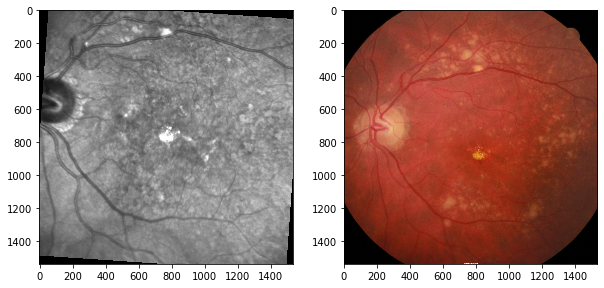

In [479]:
imageio.imwrite("/home/morelle/Projects/octave/nir.tif", nir_img)
imageio.imwrite("/home/morelle/Projects/octave/cfp.tif", cfp_img[..., 1])
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(nir_img, cmap="gray")
ax2.imshow(cfp_img, cmap="gray")

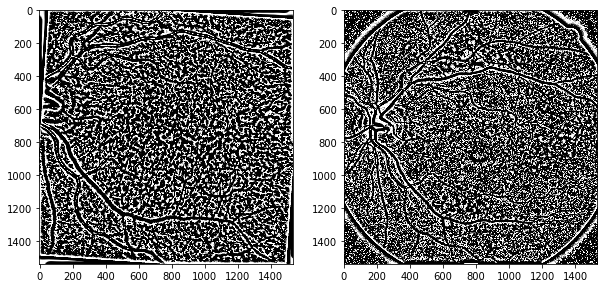

In [493]:
nir_pc = imageio.imread("/home/morelle/Projects/octave/nir_pc.tiff")
cfp_pc = imageio.imread("/home/morelle/Projects/octave/cfp_pc.tiff")

nir_pc = (nir_pc/nir_pc.max() * np.pi) -np.pi/2
cfp_pc = (cfp_pc/cfp_pc.max() * np.pi) -np.pi/2

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(nir_pc, cmap="gray")
ax2.imshow(cfp_pc, cmap="gray")

## Mean phase images

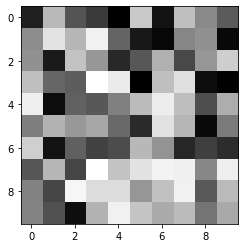

In [272]:
test = np.random.random((10,10))
plt.imshow(test, cmap="gray")

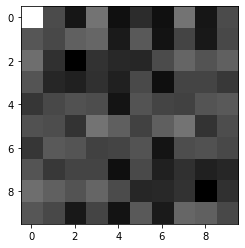

In [273]:
plt.imshow(np.log10(abs(np.fft.fft2(test))), cmap="gray")

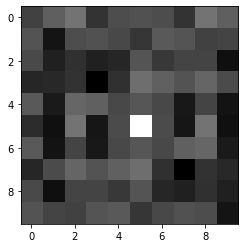

In [274]:
plt.imshow(np.fft.ifftshift(np.log10(abs(np.fft.fft2(test)))), cmap="gray")

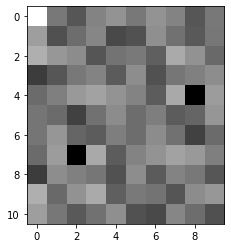

In [262]:
plt.imshow(np.log10(abs(np.fft.fft2(test))), cmap="gray")

In [203]:
np.real(np.fft.fft2(nir_img[:1535, :1535])).min()

-19787091.489047248

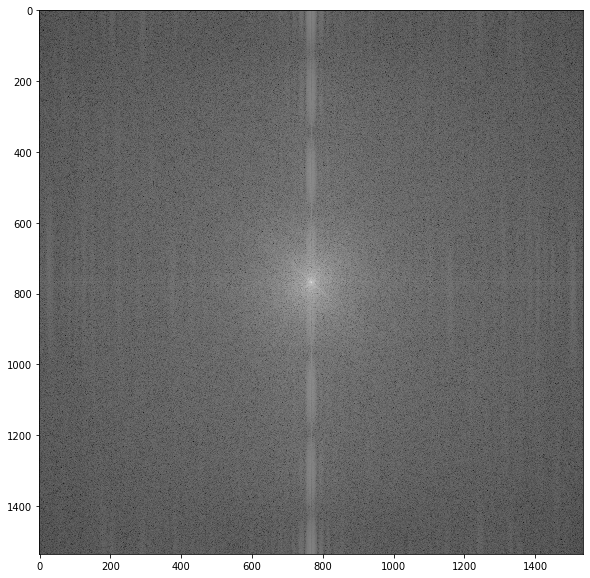

In [241]:
a = 20*np.log10(abs(np.fft.fft2(cfp_img[..., 1])))
#f = np.interp(a, (a.min(), a.max()), (0, 255)).astype(int)
#f = np.interp(f, (f.min(), 20), (0, 255))
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(np.fft.ifftshift(a), cmap="gray")

(array([2.357231e+06, 1.412000e+03, 2.700000e+02, 1.700000e+02,
        8.600000e+01, 5.200000e+01, 1.600000e+01, 1.200000e+01,
        1.000000e+01, 6.000000e+00, 0.000000e+00, 2.000000e+00,
        8.000000e+00, 4.000000e+00, 2.000000e+00, 0.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 2.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 4.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 12

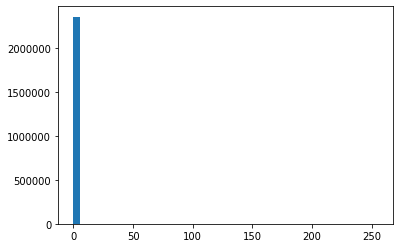

In [220]:
plt.hist(f.flatten(), bins = 50)

In [323]:
def filtergrid(size):
    """ Generates grid for constructing frequency domain filters
    
    Arguments:  rows, cols - Size of image/filter

    Returns:          x, y - Grids containing normalised frequency values
                             ranging from -0.5 to 0.5 in x and y directions
                             respectively. x and y are quadrant shifted.
    
    Inspired by filtergrid.m found at https://www.peterkovesi.com/matlabfns/
    """
    
    if type(size) is int:
        rows = cols = size
    
    else:
        rows = size[0]
        cols = size[1]
        
    range_1 = np.linspace(-(cols//2), np.floor((cols-1)/2), cols) / cols
    range_2 = np.linspace(-(rows//2), np.floor((rows-1)/2), rows) / rows
        
    x, y = np.meshgrid(range_1, range_2)
    
    #Quadrant shift so that filters are constructed with 0 frequency at the corners
    x = np.fft.ifftshift(x)
    y = np.fft.ifftshift(y)
    
    return x, y

def radius_filtergrid(size):
    """
    
    """
    
    if type(size) is int:
        rows = cols = size
    
    else:
        rows = size[0]
        cols = size[1]
        
    x, y = filtergrid(size)
    radius = np.sqrt(x**2 + y**2)
    return radius

def theta_filtergrid(size):
    """
    
    """
    
    if type(size) is int:
        rows = cols = size
    
    else:
        rows = size[0]
        cols = size[1]
        
    x, y = filtergrid(size)
    
    theta = arctan2(-y,x);              # Matrix values contain polar angle.
                                      # (note -ve y is used to give +ve
                                      # anti-clockwise angles)
    
    return theta

In [318]:
def lowpassfilter(size, cutoff, order):
    """ Constructs a low-pass butterworth filter.
    
    param size: Two element vector specifying the size of filter to construct [rows cols].
    
    param cutoff: Cutoff frequency of the filter 0 - 0.5
    param order: Order of the filter, the higher n is the sharper the transition is. 
    (n must be an integer >= 1). Note that n is doubled so that it is always an even integer.

    f = 1/ (1 + (w/cutoff))^(2*order)

    The frequency origin of the returned filter is at the corners.
    
    Inspired by lowpassfilter.m found at https://www.peterkovesi.com/matlabfns/
    """
    
    if cutoff < 0 or cutoff > 0.5:
        raise ValueError("The cutoff frequency must be between 0 and 0.5")
        
    if order != int(order) or order < 1:
        raise ValueError("order must be an iteger >= 1")
        
    if type(size) is int:
        rows = cols = size
        
    else:
        rows = size[0]
        cols = size[1]
    
    #Construct spatial frequency values in terms of normalised radius from centre.
    radius = radius_filtergrid(size)
    
    lp_filter = 1.0 / (1.0 + (radius / cutoff)**(2*order))
    
    return lp_filter


#plt.imshow(lowpassfilter((100,100), 0.45, 15))

In [317]:


orientations = [0, 30, 60, 90, 120, 150]
scales = [3,9,27,81]


        

def log_gabor_kernel(wavelength, sigma, angle, freq_domain=False):
    
    # First construct a low-pass filter that is as large as possible, yet falls
    # away to zero at the boundaries.  All log Gabor filters are multiplied by
    # this to ensure no extra frequencies at the 'corners' of the FFT are
    # incorporated as this seems to upset the normalisation process when
    # calculating phase congrunecy.
    
    freq = 1/wavelength
    radius = radius_filtergrid(freq)
    lp = lowpassfilter(freq,.45,15);  # Radius .45, 'sharpness' 15
    
    # Radial component which controls the frequency band that the filter responds to
    radial = np.exp((-(np.log(radius/freq))**2) / 
                    (2 * np.log(sigma)**2)) 
    
    # Apply low-pass filter
    radial *= lp 
    # Set the value at the 0 frequency point of the filter 
    # back to zero (undo the radius fudge).
    radial[0,0] = 0
    
    
    # The angular component, which controls the orientation that the filter responds to.
    
    # For each point in the filter matrix calculate the angular distance from
    # the specified filter orientation.  To overcome the angular wrap-around
    # problem sine difference and cosine difference values are first computed
    # and then the atan2 function is used to determine angular distance.
    ds = sintheta * cos(angl) - costheta * sin(angl);    % Difference in sine.
    dc = costheta * cos(angl) + sintheta * sin(angl);    % Difference in cosine.
    dtheta = abs(atan2(ds,dc));                          % Absolute angular distance.
    # Scale theta so that cosine spread function has the right wavelength and clamp to pi    
    dtheta = min(dtheta*norient/2,pi);
    # The spread function is cos(dtheta) between -pi and pi.  We add 1,
    # and then divide by 2 so that the value ranges 0-1
    spread = (cos(dtheta)+1)/2;

    
    
def log_gabor(image):
    image_fft = np.fft2(img)
    
    kernel = log_gabor_kernel(freq_domain=True)
    
    #pad kernel with 0
    padded_kernel = np.pad(kernel,
                           ((img.shape[0]-kernel.shape[0])/2, 
                            (img.shape[1]-kernel.shape[1])/2), 
                           mode="constant", constant_values=0)
    
    #shift kernel center to image index (0,0)
    shifted_kernel = np.ifftshift(padded_kernel)
    
    
    
    #apply kernel
    filtered_image = image_fft * shifted_kernel
    
    return np.ifft2(filtered_image)
    
    



In [322]:
from skimage.filters import gabor_kernel

gabor_kernel(3).shape

(3, 3)

In [ ]:
from skimage.filters import gabor_kernel

#cfp_gabor = gabor(cfp_img[..., 1])
#nir_gabor = gabor(nir_img)


def phase(img, frequency=5):
    gabor_real, gabor_imag = gabor(img, frequency)
    return np.arctan(abs(gabor_real)/gabor_imag)

#x = exposure.rescale_intensity(phase(cfp_img[..., 1], 0.5), in_range=(1.6, 1.7))
plt.imshow(phase(cfp_img[..., 1], 0.07), cmap="gray")

In [157]:
np.nanstd(phase(cfp_img[..., 1], 0.5))

/home/morelle/venvs/eyepy/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/morelle/venvs/eyepy/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


4.440892098500626e-16

## Apply HOG on Data

In [515]:
M=12
N=3

fd_nir, nir_hog = hog(nir_pc, orientations=12, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)


fd_cfp, cfp_hog = hog(cfp_pc, orientations=12, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)

In [516]:
fd_nir_5 = fd_nir[::5, ::5, ...]
fd_cfp_5 = fd_cfp[::5, ::5, ...]

(-0.5, 1535.5, 1535.5, -0.5)

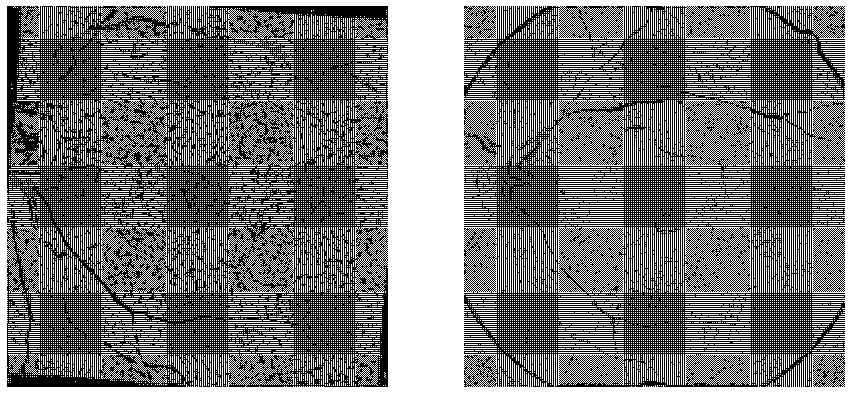

In [390]:
nir_hog_image = exposure.rescale_intensity(nir_hog, in_range=(0, 0.05))
cfp_hog_image = exposure.rescale_intensity(cfp_hog, in_range=(0, 0.05))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

s = np.s_[...]
ax1.imshow(nir_hog_image[s], cmap="gray")
ax2.imshow(cfp_hog_image[s], cmap="gray")

ax1.axis("off")
ax2.axis("off")

## Match approximate nearest neighbours in hog

Here I used a nearest neighbour approach from sklearn. I could also try to use the annoy package.

In [391]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex

def ann(src, dest, n_trees=10):
    t = AnnoyIndex(src.shape[-1], 'angular')  # Length of item vector that will be indexed
    for i in range(src.shape[0]):
        t.add_item(i, src[i])

    t.build(n_trees) # 10 trees
    
    src_1D_indices = np.empty(dest.shape[0], dtype=int)
    src_1D_dist = np.empty(dest.shape[0], dtype=int)
    for i in range(dest.shape[0]):
        ind, dist = t.get_nns_by_vector(dest[i], n=1, search_k=-1, include_distances=True)
        src_1D_indices[i] = ind[0]
        src_1D_dist[i] = dist[0]
    
    return src_1D_indices, src_1D_dist


        
    

def mutual_ann_match(src_features, dest_features):
    """
    
    features: ndarray with feature vector on the last axis 
    """  
    
    src_1D_index, src_1D_dist = ann(src_features, dest_features)
    dest_1D_index, dest_1D_dist = ann(dest_features, src_features)
    
    sort_indices = np.argsort(src_1D_dist)
    
    matches = []
    for src_ind, src_val in enumerate([x for x in src_1D_index]):
        dest_val = dest_1D_index[src_val]
        dest_ind = src_val
        
        # Check whether the nearest neighbour of neigh1 at ind
        if src_ind == dest_val and dest_ind == src_val:
            matches.append((src_ind, dest_ind))

    matches = sorted(matches, key=lambda x: src_1D_dist[x[0]] )
    
    return np.array(matches), src_1D_index, dest_1D_index

In [592]:
def ann(src, dest, n_trees=10):
    """ Searches ANN for src in dest
    
    For every feature in src the index and distanc of the ann in dest is returned 
    
    Assumes that features are on the last axis
    """
    orig_src_shape = src.shape[:-1]
    orig_dest_shape = dest.shape[:-1]
    
    # Compress index axis into one axis
    src = src.reshape((np.prod(orig_src_shape), -1))
    dest = dest.reshape((np.prod(orig_dest_shape), -1))
    
    t = AnnoyIndex(dest.shape[-1], 'euclidean')  # Length of item vector that will be indexed
    for i in range(dest.shape[0]):
        t.add_item(i, dest[i])

    t.build(n_trees)
    
    
    dest_indices = np.empty(dest.shape[0], dtype=int)
    dest_dist = np.empty(dest.shape[0], dtype=int)
    for i in range(src.shape[0]):
        ind, dist = t.get_nns_by_vector(src[i], n=1, search_k=-1, 
                                        include_distances=True)
        
        dest_indices[i], dest_dist[i] = ind[0], dist[0]
        
    # Change 1D dest indices to indices of the dest input array
    dest_indices = np.array([(x, y) for x, y in 
                             zip(*np.unravel_index(dest_indices, orig_dest_shape, order='C'))])

    
    # Reshape indices and distances to the input src shape
    dest_dist = dest_dist.reshape(orig_src_shape)
    dest_indices = dest_indices.reshape(orig_src_shape + dest_indices.shape[1:])
    
    return dest_indices, dest_dist

def mutual_ann_match(src_features, dest_features):
    """
    """
    dest_index, dest_dist = ann(src_features, dest_features)
    src_index, src_dist = ann(dest_features, src_features)
    
    
    matches = {}
    
    for i in np.ndindex(src_index.shape[:-1]):
        # i is the position in the src_index
        # nn_srcdest is the index of the nearest neighbour in dest 
        nn_srcdest = tuple(src_index[i])
        # 
        nn_destsrc = dest_index[nn_srcdest]
        if i == tuple(nn_destsrc):
            matches[src_dist[i]] = [i, tuple(dest_index[i])]
        
    return matches

In [593]:
mutual_ann_match(src_features, dest_features)

{0: [(1, 0), (1, 0)], 1: [(1, 1), (1, 0)]}

In [590]:
src_features = np.array([[1,2,3,4],[4,3,2,1],
                          [1,1,2,2], [1,1,1,2],]).reshape(2,2,4)

dest_features = np.array([[5,6,3,6], [1,1,2,1],
                           [1,1,2,2], [1,1,4,5],]).reshape(2,2,4)

src_features

array([[[1, 2, 3, 4],
        [4, 3, 2, 1]],

       [[1, 1, 2, 2],
        [1, 1, 1, 2]]])

In [594]:
dest_features

array([[[5, 6, 3, 6],
        [1, 1, 2, 1]],

       [[1, 1, 2, 2],
        [1, 1, 4, 5]]])

In [517]:
new_shape_nir = (np.prod(fd_nir_5.shape[:2]), np.prod(fd_nir_5.shape[2:]))
new_shape_cfp = (np.prod(fd_cfp_5.shape[:2]), np.prod(fd_cfp_5.shape[2:]))
matches, src, dest = mutual_ann_match(fd_cfp_5.reshape(new_shape_cfp),
                                      fd_nir_5.reshape(new_shape_nir))

In [518]:
dest_2D = np.array([(x, y) for x, y in zip(*np.unravel_index(dest, fd_nir_5.shape[:2]))])
src_2D = np.array([(x, y) for x, y in zip(*np.unravel_index(src, fd_cfp_5.shape[:2]))])
dest_2D = (dest_2D*N+(N*M/2))*5
src_2D = (src_2D*N+(N*M/2))*5

In [522]:
inliers.sum()

4

In [392]:
new_shape_nir = (np.prod(fd_nir.shape[:2]), np.prod(fd_nir.shape[2:]))
new_shape_cfp = (np.prod(fd_cfp.shape[:2]), np.prod(fd_cfp.shape[2:]))
matches, src, dest = mutual_ann_match(fd_cfp.reshape(new_shape_cfp),
                                      fd_nir.reshape(new_shape_nir))

In [393]:
dest_2D = np.array([(x, y) for x, y in zip(*np.unravel_index(dest, fd_nir.shape[:2]))])
src_2D = np.array([(x, y) for x, y in zip(*np.unravel_index(src, fd_cfp.shape[:2]))])
dest_2D = dest_2D*N+(N*M/2)
src_2D = src_2D*N+(N*M/2)

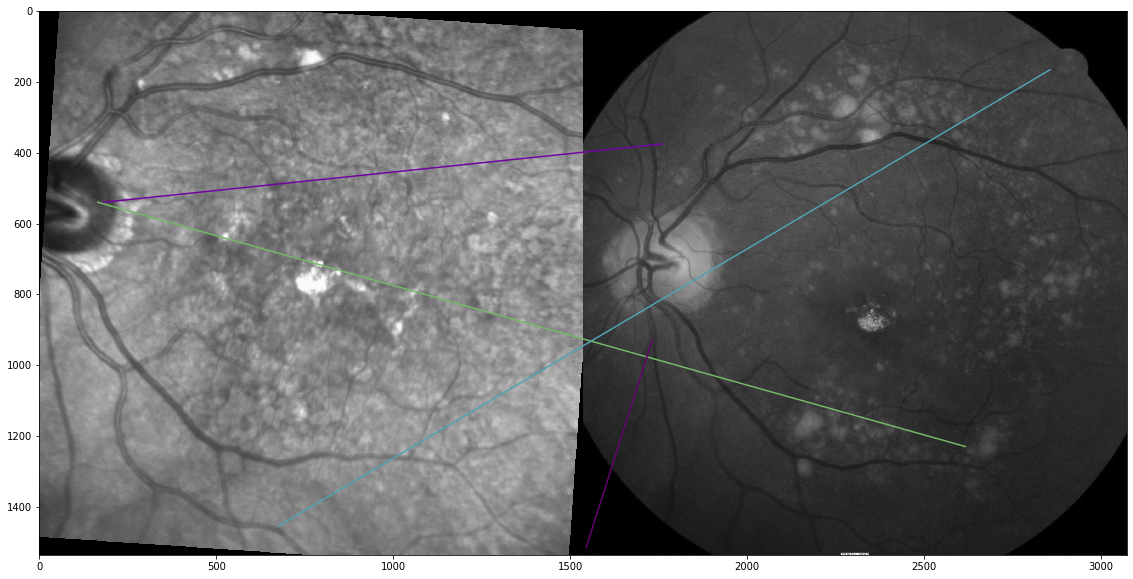

In [523]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_matches(ax, nir_img, cfp_img[..., 1], dest_2D, src_2D, matches[inliers][:30], only_matches=True)

## Use RANSAC for robust estimation of affine transformation

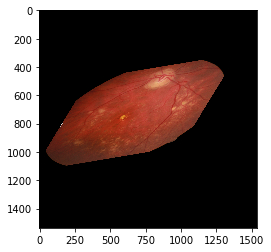

In [520]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

model_robust, inliers = ransac((src_2D[matches[:, 0]], dest_2D[matches[:, 1]]), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=10000)
outliers = inliers == False

transformed_cfp = warp(cfp_img, model_robust.inverse, )#output_shape=nir_img.shape)
plt.imshow((gray2rgb(transformed_cfp*255).astype(int)))

In [473]:
#output_shape=nir_img.shape)

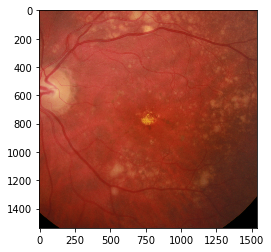

In [474]:
plt.imshow((gray2rgb(transformed_cfp*255).astype(int)))

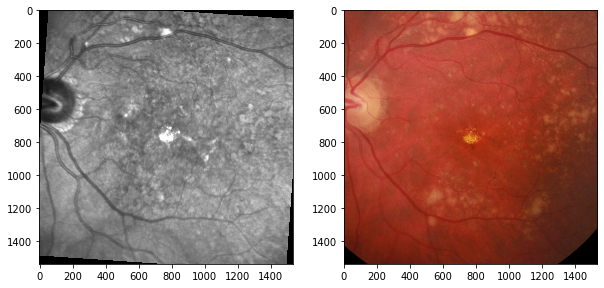

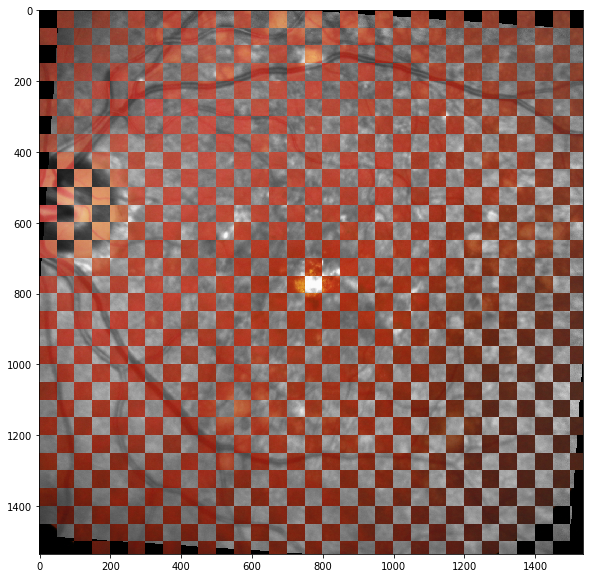

In [477]:
plot_registration_comparison(nir_img, transformed_cfp, square_size=50)

# Example code

Ground truth:
Scale: (0.9000, 0.9000), Translation: (-10.0000, 20.0000), Rotation: -0.2000
Affine transform:
Scale: (0.9015, 0.8913), Translation: (-9.3136, 14.9768), Rotation: -0.1678
RANSAC:
Scale: (0.8999, 0.9001), Translation: (-10.0005, 19.9744), Rotation: -0.1999


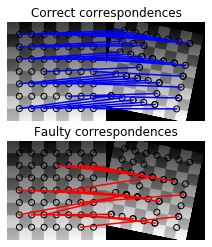

In [169]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac


# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print("Ground truth:")
print(f"Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), "
      f"Translation: ({tform.translation[1]:.4f}, "
      f"{tform.translation[0]:.4f}), "
      f"Rotation: {-tform.rotation:.4f}")
print("Affine transform:")
print(f"Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), "
      f"Translation: ({model.translation[0]:.4f}, "
      f"{model.translation[1]:.4f}), "
      f"Rotation: {model.rotation:.4f}")
print("RANSAC:")
print(f"Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), "
      f"Translation: ({model_robust.translation[0]:.4f}, "
      f"{model_robust.translation[1]:.4f}), "
      f"Rotation: {model_robust.rotation:.4f}")

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

In [172]:
x

array([], dtype=float64)

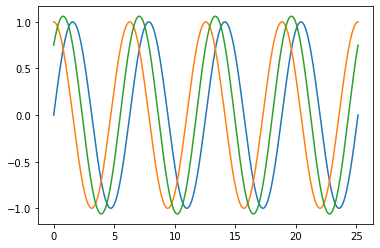

In [181]:
x = np.linspace(0,8*np.pi, 1000)
sin = np.sin(x) #+ np.cos(x)
cos = np.cos(x)
sc = 0.75*sin + .75*cos
plt.plot(x, sin)
plt.plot(x, cos)
plt.plot(x, sc)